# CNN Refactor: Parser y Perspectiva Corregidos + Regularización

Objetivo: corregir el preprocesamiento (etiquetado y normalización de perspectiva) y entrenar un modelo CNN regularizado para mejorar la generalización.

## Cambios clave (concepto → acción)
- Etiquetas coherentes: convertir `Evaluation` a centipawns (cp) y mapear mates a ±10000 cp; clasificar con umbrales ±150 cp.
- Perspectiva corregida: si mueve negras, solo se invierte verticalmente (ranks) y se swappean colores; no se invierten columnas.
- Sin invertir la clase: al normalizar perspectiva, ya no se transforma la etiqueta (0/1/2).
- Modelo regularizado: Conv2D más pequeño + BatchNorm + Dropout + L2 + GlobalAveragePooling2D.
- Entrenamiento robusto: early stopping (val_loss) + ReduceLROnPlateau; reporte y matriz de confusión.

In [1]:
# Imports y configuración de paths
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

DATA_DIR = Path('../data/processed')
assert (DATA_DIR / 'training_data.parquet').exists(), 'Falta data procesada. Ejecuta el split previo.'

## Parser de Evaluación (a centipawns)
- Convierte distintas representaciones a cp:
  - Flotantes con punto → pawns × 100 (ej. `2.5` → 250).
  - Enteros o con `+`/`-` sin punto → cp directos (ej. `+34` → 34).
  - Mates `#±N` o variantes → ±10000 cp.
- Clasificación en 3 clases con umbrales ±150 cp.

In [2]:
def eval_to_centipawns(eval_str: str) -> float:
    s = str(eval_str).strip()
    if not s:
        return 0.0
    # Mates tipo '#3' o '#-2'
    if s.startswith('#'):
        try:
            v = float(s[1:])
            return 10000.0 if v >= 0 else -10000.0
        except Exception:
            return 0.0
    # Intento de float genérico
    try:
        v = float(s)
    except Exception:
        return 0.0
    # Heurística: si tenía punto decimal, lo interpretamos como pawns
    if '.' in s:
        return v * 100.0
    # De lo contrario, asumimos cp directo
    return v

def cp_to_class(cp: float, thr: int = 150) -> int:
    if cp > thr:
        return 0  # Ventaja blanca
    if cp < -thr:
        return 2  # Ventaja negra
    return 1       # Empate/equilibrado

# Pruebas rápidas
tests = ['#3', '#-2', '+34', '-178', '2.5', '-1.8', '0.0']
[(t, eval_to_centipawns(t), cp_to_class(eval_to_centipawns(t))) for t in tests]

[('#3', 10000.0, 0),
 ('#-2', -10000.0, 2),
 ('+34', 34.0, 1),
 ('-178', -178.0, 2),
 ('2.5', 250.0, 0),
 ('-1.8', -180.0, 2),
 ('0.0', 0.0, 1)]

## Parser de FEN y normalización de perspectiva
- Representación one-hot 8×8×12: [P,N,B,R,Q,K]×[blanca, negra].
- Si mueve negras: swapcase (colores) + flip vertical (orden de filas).
- No se invierten columnas; la clase ya no se transforma.

In [3]:
def create_piece_mapping():
    pieces = ['P','N','B','R','Q','K']
    return {p: i for i, p in enumerate(pieces)}

PIECE_MAPPING = create_piece_mapping()

def parse_board_row(row_string: str, piece_mapping: dict) -> list[list[int]]:
    row_squares = []
    for ch in row_string:
        vec = [0] * (len(piece_mapping) * 2)
        if ch in piece_mapping:  # blanca
            vec[piece_mapping[ch]] = 1
            row_squares.append(vec)
        elif ch.upper() in piece_mapping:  # negra
            vec[piece_mapping[ch.upper()] + len(piece_mapping)] = 1
            row_squares.append(vec)
        elif ch.isdigit():  # vacías
            for _ in range(int(ch)):
                row_squares.append(vec.copy())
        else:
            # separadores u otros símbolos no esperados
            pass
    return row_squares

def parse_fen_to_tensor_fixed(fen_string: str, piece_mapping: dict) -> tuple[np.ndarray, bool]:
    parts = fen_string.split(' ')
    board = parts[0]
    active = parts[1] if len(parts) > 1 else 'w'
    is_black_turn = (active == 'b')
    # swapcase de colores si juega negras
    if is_black_turn:
        board_proc = board.swapcase()
        rows = board_proc.split('/')
        rows = list(reversed(rows))  # flip vertical (ranks)
    else:
        rows = board.split('/')
    board_rows = [parse_board_row(r, piece_mapping) for r in rows]
    tensor = np.array(board_rows, dtype=np.float32)
    return tensor, is_black_turn

# Prueba rápida
initial_fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
t_w, is_b = parse_fen_to_tensor_fixed(initial_fen, PIECE_MAPPING)
t_b, is_b2 = parse_fen_to_tensor_fixed(initial_fen.replace(' w ', ' b '), PIECE_MAPPING)
t_w.shape, is_b, t_b.shape, is_b2

((8, 8, 12), False, (8, 8, 12), True)

## Preprocesamiento fila → (tensor, clase)
- `FEN` → tensor 8×8×12
- `Evaluation` → cp → clase (0/1/2) → one-hot
- Nota: sin inversión de clase cuando juega negras.

In [4]:
def preprocess_row(row: pd.Series, piece_mapping: dict) -> tuple[np.ndarray, np.ndarray]:
    fen = row['FEN']
    ev = row['Evaluation']
    board_tensor, is_black_turn = parse_fen_to_tensor_fixed(fen, piece_mapping)
    cp = eval_to_centipawns(str(ev))
    cls = cp_to_class(cp)
    y = np.zeros(3, dtype=np.float32)
    y[cls] = 1.0
    return board_tensor, y

def create_Xy(df: pd.DataFrame, max_samples: int | None = None) -> tuple[np.ndarray, np.ndarray]:
    if max_samples:
        df = df.head(max_samples)
    X_list, y_list = [], []
    for _, r in df.iterrows():
        try:
            x, y = preprocess_row(r, PIECE_MAPPING)
            X_list.append(x)
            y_list.append(y)
        except Exception:
            continue
    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y

## Carga de datos y muestreo
- Leemos Parquet persistidos en `data/processed`.
- Por defecto usamos tamaños moderados para prueba; ajusta `MAX_*` según RAM.

In [ ]:
# Tamaños por defecto (ajustables)
MAX_TRAIN = int(os.environ.get('MAX_TRAIN', 50_000))
MAX_VAL   = int(os.environ.get('MAX_VAL',   10_000))
MAX_TEST  = int(os.environ.get('MAX_TEST',  10_000))

train_df = pd.read_parquet(DATA_DIR / 'training_data.parquet')
val_df   = pd.read_parquet(DATA_DIR / 'validation_data.parquet')
test_df  = pd.read_parquet(DATA_DIR / 'testing_data.parquet')

print(f'Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}')

X_train, y_train = create_Xy(train_df, MAX_TRAIN)
X_val,   y_val   = create_Xy(val_df,   MAX_VAL)
X_test,  y_test  = create_Xy(test_df,  MAX_TEST)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

Train: 11,610,568 | Val: 3,317,307 | Test: 1,658,652


((50000, 8, 8, 12),
 (50000, 3),
 (10000, 8, 8, 12),
 (10000, 3),
 (10000, 8, 8, 12),
 (10000, 3))

## Modelo CNN regularizado
- Arquitectura compacta con regularización explícita.
- Evitamos `Flatten`; usamos `GlobalAveragePooling2D`.
- Métrica: `categorical_accuracy`.

In [6]:
def build_model(input_shape=(8,8,12), l2w=1e-4, dp=0.4):
    m = Sequential([
        Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(l2w), input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(l2w)),
        BatchNormalization(),
        Dropout(dp),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu', kernel_regularizer=l2(l2w)),
        Dropout(dp),
        Dense(3, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return m

model = build_model()
model.summary()

c:\Users\samir\Documents\noveno semestre\aprendizaje maquina\stocksalmon\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 64)       │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,771 (190.51 KB)

 Trainable params: 48,515 (189.51 KB)

 Non-trainable params: 256 (1.00 KB)

## Entrenamiento
- EarlyStopping monitoriza `val_loss`.
- ReduceLROnPlateau disminuye LR si no hay mejora.

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - categorical_accuracy: 0.5094 - loss: 0.9892 - val_categorical_accuracy: 0.5230 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - categorical_accuracy: 0.5401 - loss: 0.9541 - val_categorical_accuracy: 0.5376 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - categorical_accuracy: 0.5459 - loss: 0.9405 - val_categorical_accuracy: 0.5400 - val_loss: 0.9520 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - categorical_accuracy: 0.5515 - loss: 0.9340 - val_categorical_accuracy: 0.5438 - val_loss: 0.9490 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - categorical_accuracy: 0.5575 - loss: 0.9265 - val_categorical_accuracy: 0.5538 - val_loss: 0.9381 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - categorical_accuracy: 0.5621 - loss: 0.9207 - val_categorical_accu

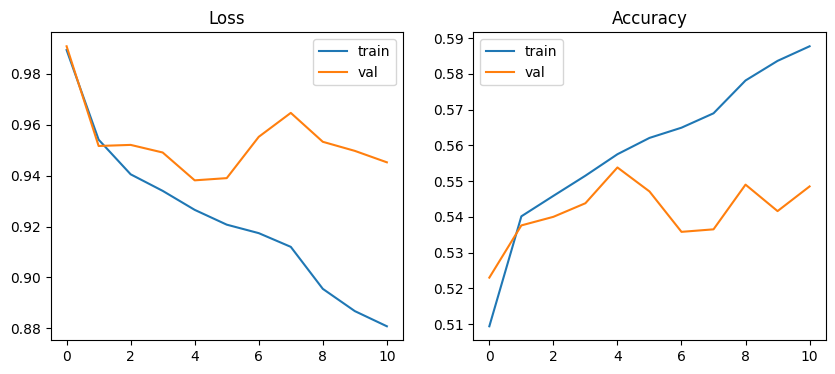

In [7]:
early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
rlr   = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=64,
    callbacks=[early, rlr],
    verbose=1
)

# Curvas de pérdida y accuracy
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history.history['loss'], label='train'); ax[0].plot(history.history['val_loss'], label='val'); ax[0].set_title('Loss'); ax[0].legend();
ax[1].plot(history.history['categorical_accuracy'], label='train'); ax[1].plot(history.history['val_categorical_accuracy'], label='val'); ax[1].set_title('Accuracy'); ax[1].legend();
plt.show()

## Evaluación en Test
- Reporte de clasificación y matriz de confusión.

              precision    recall  f1-score   support

      Blanca       0.44      0.53      0.48      2980
      Empate       0.64      0.81      0.71      4812
       Negra       0.44      0.07      0.11      2208

    accuracy                           0.56     10000
   macro avg       0.51      0.47      0.44     10000
weighted avg       0.54      0.56      0.51     10000



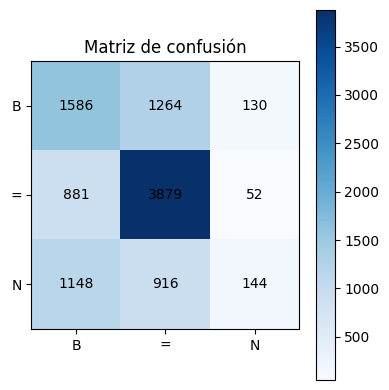

In [8]:
pred = model.predict(X_test, verbose=0)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(pred, axis=1)

print(classification_report(y_true, y_pred, target_names=['Blanca','Empate','Negra']))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(['B','=','N']); ax.set_yticklabels(['B','=', 'N'])
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center')
ax.set_title('Matriz de confusión')
plt.colorbar(im); plt.tight_layout(); plt.show()

## Notas finales
- Este cuaderno estandariza el target y corrige la perspectiva, reduciendo ruido de etiquetado.
- La arquitectura regularizada y GAP ayudan a disminuir el overfitting.
- Ajusta `MAX_*` y el modelo según recursos; para mayores tamaños usa `tf.data` para streaming.